
# ** Scientific Computing**
> Grace Esther



## Libraries & Processing

In [ ]:
# Import needed library
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from scipy.optimize import fsolve

In [ ]:
# Open csv and quick analysis
df = pd.read_csv('aol_data.csv')
df.head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,...,M135,M136,M137,M138,M139,M140,M141,M142,M143,M144
0,1863,1614,2570,1685,2101,1811,2457,2171,2134,2502,...,14917,15046,15556,15893,16388,16782,16716,17033,16896,17689


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 144 entries, M1 to M144
dtypes: int64(144)
memory usage: 1.2 KB


In [ ]:
# Change data to time series format
production = df.values.flatten()

In [ ]:
# Make df and time initial from the data started until ended (jan 2018 - dec 2023)
date_range = pd.date_range(start='2018-01', periods=len(production) // 2, freq='M')
production_avg = production.reshape(-1, 2).mean(axis=1)

production_df = pd.DataFrame({
    'Month': date_range,  # Each month corresponds to the averaged production data
    'Production': production_avg
})

<ipython-input-32-65409d3c11fe>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start='2018-01', periods=len(production) // 2, freq='M')


In [ ]:
# Add time column
production_df['Time'] = range(1, len(production_df) + 1)

# **Case 1**

Polynomial regression was chosen to model the sales trend due to its ability to capture the non-linear relationship between time and production. The production data exhibited a trend that couldn't be effectively modeled by a simple linear regression, so I explored polynomial regression, which can accommodate more complex patterns.

In [ ]:
x = production_df['Time'].values
y = production_df['Production'].values

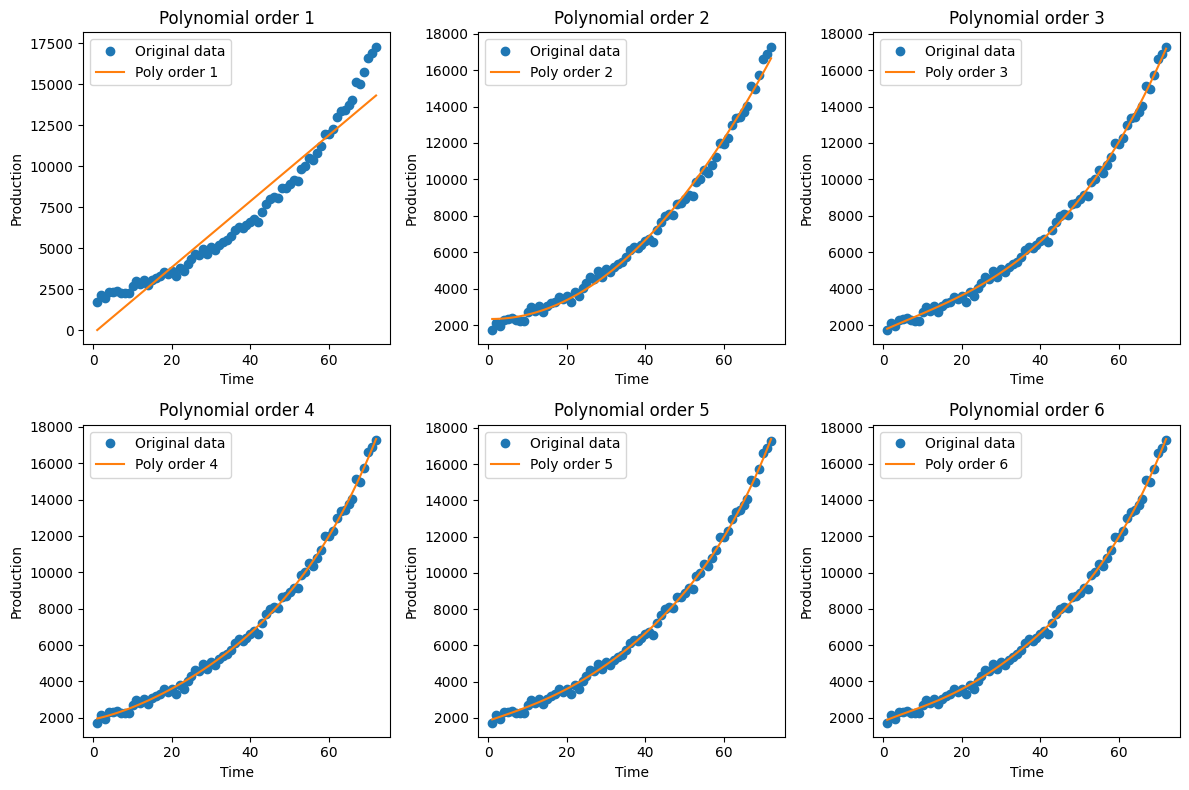

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.plot(x, y, 'o', label='Original data')

    # Fit a polynomial of degree i
    y_est = np.polyfit(x, y, i)
    plt.plot(x, np.polyval(y_est, x), label=f'Poly order {i}')

    plt.title(f'Polynomial order {i}')
    plt.xlabel('Time')
    plt.ylabel('Production')
    plt.legend()

plt.tight_layout()
plt.show()

By fitting polynomials of increasing degrees (1 through 6), we were able to find an optimal balance between model complexity and accuracy, as higher-degree polynomials showed diminishing improvements in prediction performance, suggesting they didn't provide significant additional value.

# **Case 2**

To ensure the model's robustness, I used cross-validation and MSE as the evaluation metric, preventing overfitting and confirming that the model generalizes well to unseen data.

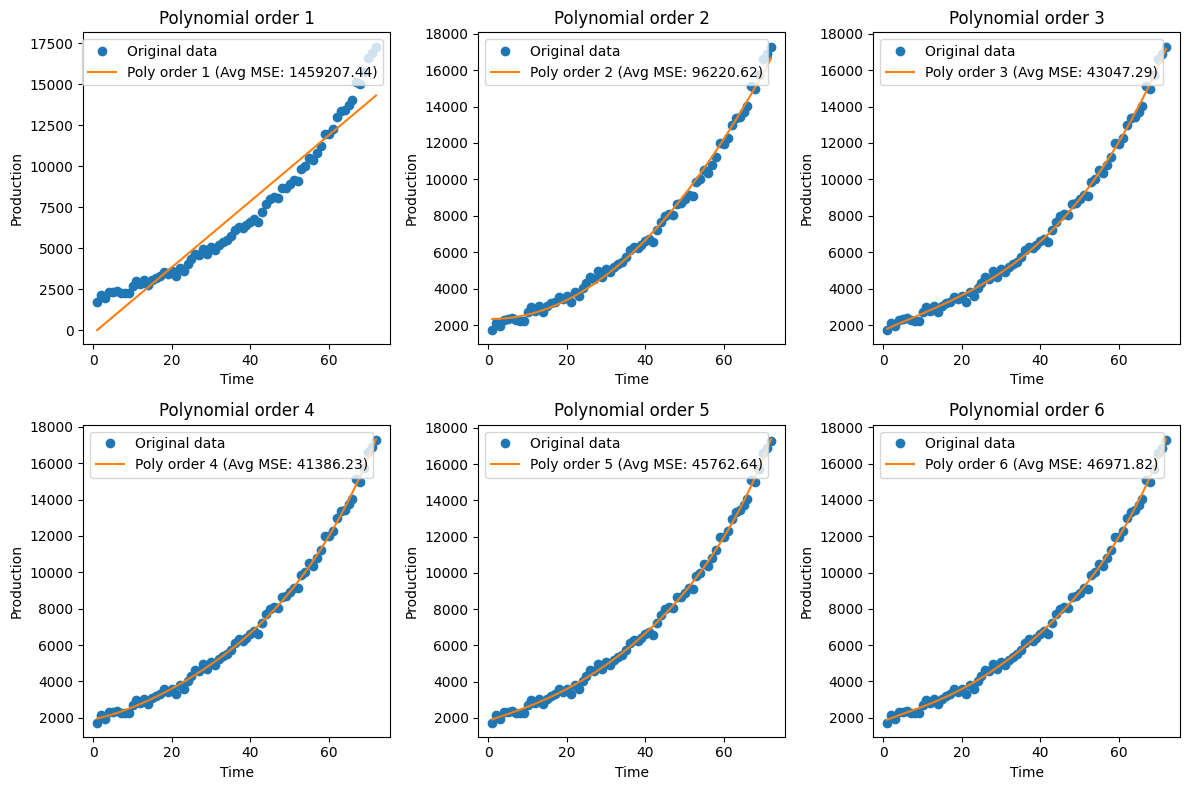

In [ ]:
plt.figure(figsize=(12, 8))

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.plot(x, y, 'o', label='Original data')

    # Store the mean MSE across all folds for the current polynomial degree
    mse_values = []


    for train_index, val_index in kf.split(x):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]

        y_est = np.polyfit(x_train, y_train, i)

        y_pred = np.polyval(y_est, x_val)


        mse = mean_squared_error(y_val, y_pred)
        mse_values.append(mse)

    avg_mse = np.mean(mse_values)

    y_est_full = np.polyfit(x, y, i)
    plt.plot(x, np.polyval(y_est_full, x), label=f'Poly order {i} (Avg MSE: {avg_mse:.2f})')

    plt.title(f'Polynomial order {i}')
    plt.xlabel('Time')
    plt.ylabel('Production')
    plt.legend()

plt.tight_layout()
plt.show()

I've applied a cross-validation technique to evaluate the performance of polynomial regression models of various degrees (1 through 6) on our dataset. The results are as follows:

Linear model (Order 1): MSE = 1,459,207.44, which indicates poor fit to the data.

Higher-order polynomials (Order 2 to 6) show progressively better fits with decreasing MSE values. However, after the cubic polynomial (Order 3), the improvements in error reduction are minimal.

This suggests that while higher-order polynomials fit the data better, the gains become marginal, indicating a possible risk of overfitting. Particularly for Orders 4 and above, the model might become too complex, fitting noise rather than the underlying trend.

Based on these results, Order 3 (Cubic) seems to be the best balance between model complexity and accuracy, providing sufficient flexibility to capture the data’s underlying trend without overfitting.

In conclusion, these results suggest that the cubic polynomial model is the most appropriate given the current data.

In [ ]:
# 3 since it's the best one (based on previous analysis)
degree = 3
coefficients = np.polyfit(x, y, degree)

# Find the roots of the polynomial equation, where y equals 0
roots = np.roots(coefficients)

# Check each root
for root in roots:
    if np.isreal(root):
        root = np.real(root)
        print('x where y=0')
        print(f"Root of the polynomial: {root}")

        # Check if the root is within the range of the dataset
        if root < production_df['Time'].min() or root > production_df['Time'].max():
            print("The root lies beyond the dataset's range.")
        else:
            print("The root falls within the dataset's range.")

x where y=0
Root of the polynomial: -15.378499184851686
The root lies beyond the dataset's range.


In [ ]:
# Identify negative trend points
negative_points = production_df[production_df['Time'] > root] if coefficients[0] < 0 else []
print(f"Negative trend data points: {negative_points}")

Negative trend data points: []


The root of the polynomial, where y=0, is approximately -15.378, which falls outside the range of the dataset. This indicates that the production level does not drop to zero within the observed period, and there are no negative trend data points. As a result, the model does not predict a decline in production during the timeframe analyzed, making the zero-production point irrelevant for our current analysis.

# **Case 3**

The resulting polynomial regression model was then used to predict when production would exceed 25,000 bags, providing the timeline for when a new warehouse would be needed, taking into account the 13-month lead time.

In [ ]:
coefficients = np.polyfit(x, y, 3)
a3, a2, a1, a0 = coefficients

In [ ]:
def production_at_time(t):
    return a3 * t**3 + a2 * t**2 + a1 * t + a0

In [ ]:
def find_time_to_exceed_capacity(t):
    return production_at_time(t) - 25000

In [ ]:
initial_guess = 90

In [ ]:
time_when_exceeds_capacity = fsolve(find_time_to_exceed_capacity, initial_guess)[0]
print(f"Production exceeds 25,000 bags at month {time_when_exceeds_capacity:.3f}")

Production exceeds 25,000 bags at month 85.420


In [ ]:
start_building_time = time_when_exceeds_capacity - 13
print(f"EGIER needs to start building the new warehouse at month {start_building_time:.3f}")

EGIER needs to start building the new warehouse at month 72.420


By solving the polynomial equation, it determines that production will surpass this capacity at 85.42 months. To ensure readiness, the warehouse construction should start by 72.42 months, allowing 13 months of preparation. This approach provides a clear timeline for decision-making based on production trends.

We can use Taylor Series as well

In [ ]:
def taylor_series(t, t0, order):
    derivatives = [
        lambda t: a3 * t**3 + a2 * t**2 + a1 * t + a0,
        lambda t: 3 * a3 * t**2 + 2 * a2 * t + a1,
        lambda t: 6 * a3 * t + 2 * a2,
        lambda t: 6 * a3
    ]
    expansion = derivatives[0](t0)
    factorial = 1

    for n in range(1, order + 1):
        factorial *= n
        expansion += (derivatives[n](t0) * (t - t0)**n) / factorial

    return expansion

In [ ]:
def find_time_to_exceed_capacity(t):
    t0 = 90
    order = 3
    return taylor_series(t, t0, order) - 25000

In [ ]:
initial_guess = 90
time_when_exceeds_capacity = fsolve(find_time_to_exceed_capacity, initial_guess)[0]
print(f"Production exceeds 25,000 bags at month {time_when_exceeds_capacity:.3f}")

Production exceeds 25,000 bags at month 85.420


In [ ]:
start_building_time = time_when_exceeds_capacity - 13
print(f"EGIER needs to start building the new warehouse at month {start_building_time:.3f}")

EGIER needs to start building the new warehouse at month 72.420


In [ ]:
# Months from 70 to 100
t = np.linspace(70, 100, 500)
production_values = production_at_time(t)

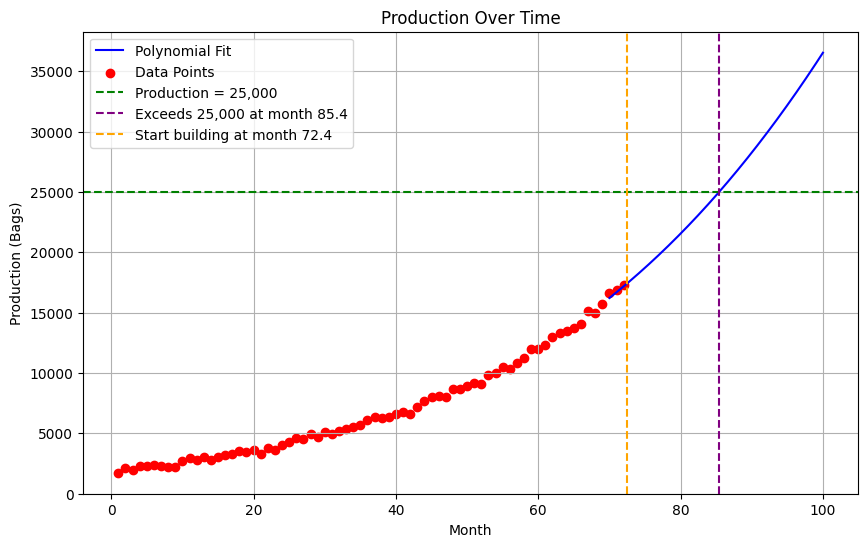

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t, production_values, label="Polynomial Fit", color="blue")
plt.scatter(x, y, color="red", label="Data Points")

plt.axhline(25000, color="green", linestyle="--", label="Production = 25,000")
plt.axvline(time_when_exceeds_capacity, color="purple", linestyle="--", label=f"Exceeds 25,000 at month {time_when_exceeds_capacity:.1f}")
plt.axvline(start_building_time, color="orange", linestyle="--", label=f"Start building at month {start_building_time:.1f}")

plt.title("Production Over Time")
plt.xlabel("Month")
plt.ylabel("Production (Bags)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print('Thank You')

Thank You
